In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


In [2]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})
import lalsimulation as lalsim
import phenom
import numpy as np

import waveform_generator
import hybrid_utils
import pn_taylor_eob

<Figure size 640x480 with 0 Axes>

/opt/homebrew/Caskroom/miniforge/base/envs/lmfit/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [5]:
# I don't think this equation is quite correct.
# it doesn't seem to work for the (4,4) mode..
def delta_phi_fn(m):
    z = (-1)*(-1.j)**m
    return np.arctan2(z.imag, z.real)

In [6]:
# modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
# modes = [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5),(5,4)]
# modes = [(2,2),(2,1),(3,3),(4,4)]
modes = [(2,2),(3,2),(4,4)]

In [7]:
nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
# nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10


# nr_hdf5_filename="/Users/sebastian.khan/Downloads/MAYA0909.h5"

# nr_hdf5_filename="/Users/sebastian.khan/Downloads/ExtrapStrain_RIT-BBH-0245-n120.h5"
# nr_hdf5_filename="/Users/sebastian.khan/Downloads/ExtrapStrain_RIT-BBH-0337-n120.h5"

# sample spacing in units of M for output NR time series
delta_t=0.1
wf_nr = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)

print(wf_nr['metadata'])

# should add a test is mass-ratio == 1 and spins are equal then don't include odd-m modes
# try:
#     np.testing.assert_approx_equal(wf_nr['metadata']['q'], 1)
#     modes = [(2,2),(3,2),(4,4)]
# except:
#     pass

# f_min=20
# f_min=16
f_min=13

# wf_pn = waveform_generator.generate_pn_waveform(
#     q=wf_nr['metadata']['q'],
#     modes=modes,
#     f_min=f_min,
#     S1z=wf_nr['metadata']['spin1z']*0,
#     S2z=wf_nr['metadata']['spin2z']*0,
#     # approximant=lalsim.IMRPhenomTHM
#     approximant=lalsim.NRHybSur3dq8
#     # approximant=lalsim.TaylorT1
#     # approximant=lalsim.SpinTaylorT1
#     # approximant=lalsim.SEOBNRv4PHM
# )


# fake nr with another model
# wf_nr = waveform_generator.generate_pn_waveform(
#     q=wf_nr['metadata']['q'],
#     modes=modes,
#     # f_min=f_min+4,
#     f_min=20,
#     S1z=wf_nr['metadata']['spin1z'],
#     S2z=wf_nr['metadata']['spin2z'],
#     approximant=lalsim.IMRPhenomTHM
#     # approximant=lalsim.NRHybSur3dq8
#     # approximant=lalsim.SpinTaylorT4
# )


# using EOB for 22 mode and PN amplitudes
wf_pn = pn_taylor_eob.generate_pn_waveform_eob(
    wf_nr['metadata']['q'],
    modes=modes,
    f_min=f_min,
    S1z=wf_nr['metadata']['spin1z'],
    S2z=wf_nr['metadata']['spin2z']
)



{'q': 1.000000000542, 'filename': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5', 'M': 0.999999970503, 'spin1z': -3.67050658542e-09, 'spin2z': -2.1572848954e-09}


In [8]:
phenom.HztoMf(13, 50) * np.pi

0.010058026173753298

In [9]:
phenom.MftoHz(0.01 * 2 / 2 / np.pi, 50)

12.925001163671523

In [10]:
# ### julia

# # Start the Julia session
# from juliacall import Main as jl

# # Import `PostNewtonian` in the Julia session
# jl.seval("using PostNewtonian")

# def delta_from_m1_m2(m1, m2):
#     return (m1 - m2) / (m1 + m2)

# def gwframes_pnwaveform(q, M=50, chi1=np.array([0,0,0]), chi2=np.array([0,0,0]), Omega_i=0.01, approximant="TaylorT1", ell_min=2, ell_max=4, inertial=True, return_raw=False):
#     """
#     Omega_i: orbital angular frequency at initial instant.
#         I assume this is in dimensionless units
#     """
#     m1, m2 = phenom.m1_m2_M_q(M, q)
#     delta = delta_from_m1_m2(m1, m2)

#     # Call into Julia to run some function
#     w = jl.GWFrames.PNWaveform("TaylorT1", delta, chi1, chi2, Omega_i, ell_max=ell_max, inertial=inertial)

#     if return_raw:
#         return w
#     else:
#         times = w.t.to_numpy()
#         hlm_array = w.data.to_numpy()

#         hlm={}
#         i = 0
#         for l in range(ell_min, ell_max+1):
#             for m in range(-l, l+1):
#                 key = (l,m)
#                 hlm[key] = hlm_array[:,i]
#                 # hlm[key] = (1.j)**m * hlm_array[:,i]
#                 i+=1

#         # conventions...
#         hlm_ = {}
#         for l in range(ell_min, ell_max+1):
#             for m in range(-l, l+1):
#                 # hlm_[l,m] = (-1)**l * np.conj(hlm[l,-m]) * (1.j)**m
#                 # hlm_[l,m] = hlm[l,m]*(1.j)**m
#                 hlm_[l,m] = hlm[l,-m]
#                 # hlm_[l,m] = (1.j)**m * hlm_[l,m]
#                 # hlm_[l,-m] = hlm_[l,m] #hackhackhack to get sign(phase) of pn to be same as nr for testing
#         hlm = hlm_
        
#         # align so last time point is at 0
#         times = times - times[-1]
#         wf = {}
#         wf['t'] = times
#         wf['hlm'] = hlm
#         return wf


# Omega_i = phenom.HztoMf(f_min, 50) * np.pi
# print(Omega_i)
# wf_pn = gwframes_pnwaveform(wf_nr['metadata']['q'], Omega_i=Omega_i)

# hlm_ = {}
# for mode in modes:
#     hlm_[mode] = wf_pn['hlm'][mode].copy()
# wf_pn['hlm'] = hlm_.copy()

# ####

In [11]:
# # apply a polarisaiton shift
# # psi0 = -np.pi
# psi0 = np.pi
# # psi0 = 0

# hlms = wf_pn['hlm'].copy()
# for mode in hlms.keys():
#     hlms[mode] = hlms[mode] * np.exp(1.j*psi0)
# wf_pn['hlm'] = hlms.copy()

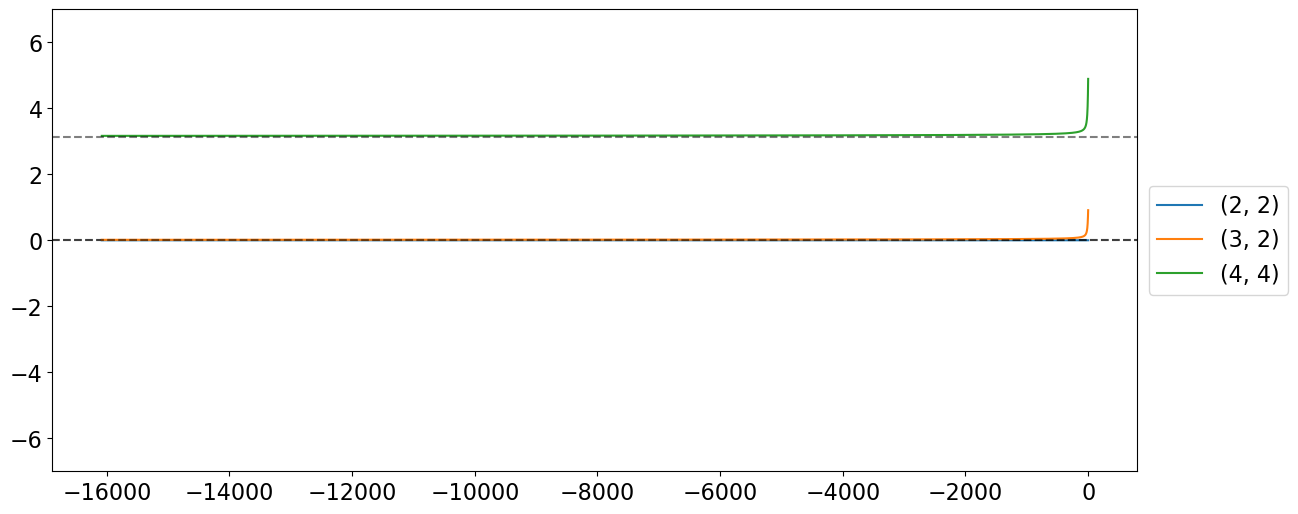

In [12]:
wf_pn = hybrid_utils.compute_phase(wf_pn)
plt.figure(figsize=(14, 6), dpi=100)
for mode in wf_pn['hlm'].keys():
    ell=mode[0]
    mm=mode[1]
    # plt.plot(wf_pn['t'], wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm), label=mode)
    plt.plot(wf_pn['t'], np.unwrap(wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)), label=mode)
    plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
plt.ylim(-7, 7)
# plt.xlim(-1000, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

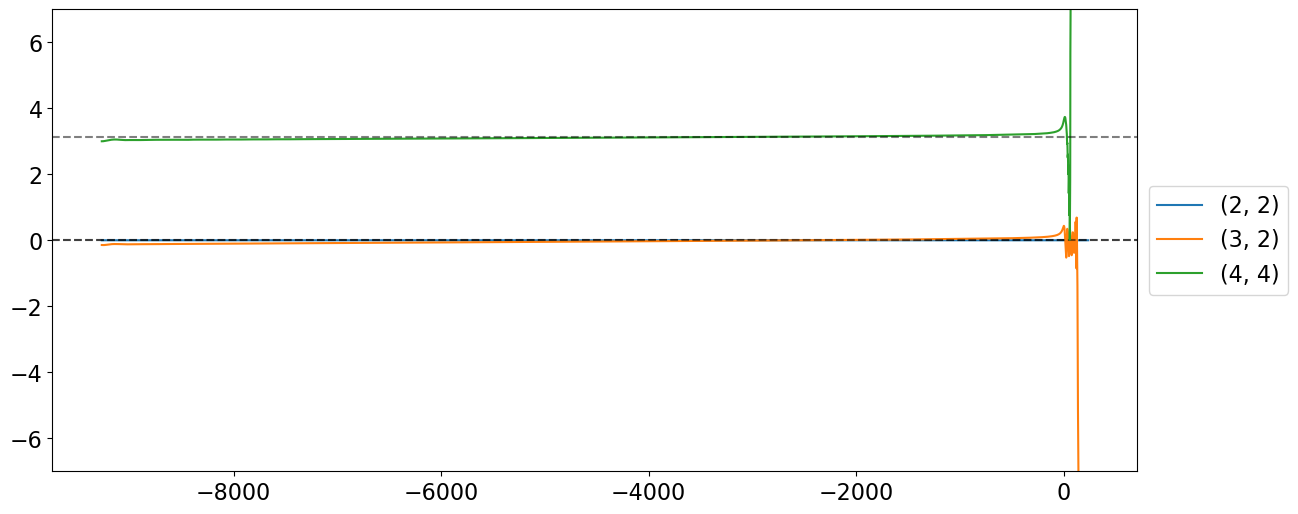

In [13]:
wf_nr = hybrid_utils.compute_phase(wf_nr)
plt.figure(figsize=(14, 6), dpi=100)
for mode in wf_pn['hlm'].keys():
    ell=mode[0]
    mm=mode[1]
    plt.plot(wf_nr['t'], np.unwrap(wf_nr['phase'][mode] - (wf_nr['phase'][2,2]/2 * mm)), label=mode)
    plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
plt.ylim(-7, 7)
# plt.xlim(-1000, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

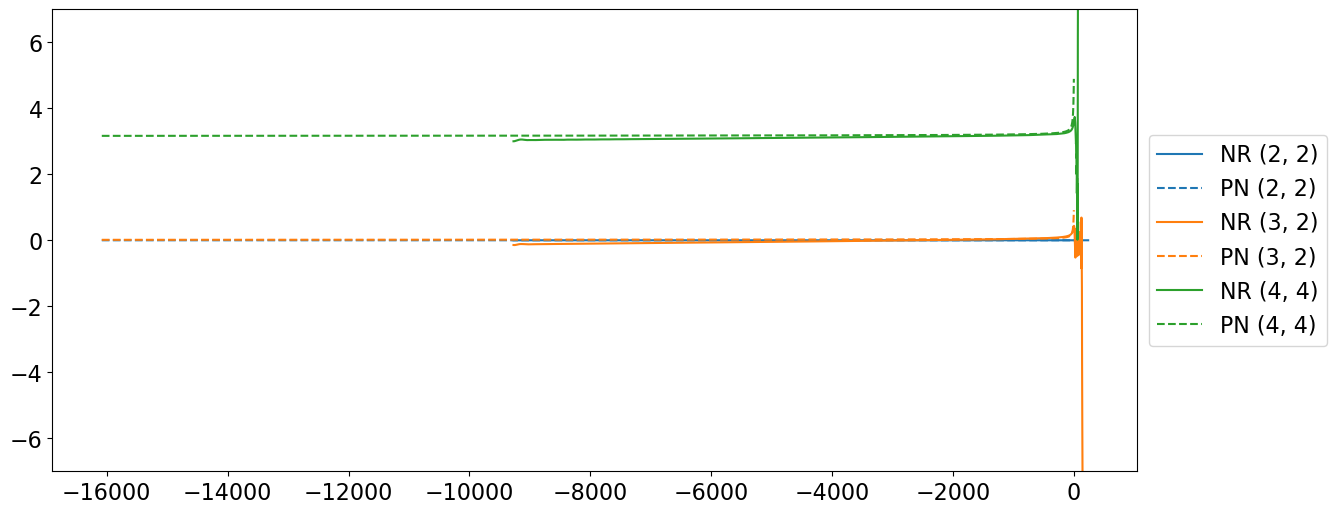

In [14]:
wf_nr = hybrid_utils.compute_phase(wf_nr)
plt.figure(figsize=(14, 6), dpi=100)
for i, mode in enumerate(wf_pn['hlm'].keys()):
    ell=mode[0]
    mm=mode[1]
    plt.plot(wf_nr['t'], np.unwrap(wf_nr['phase'][mode] - (wf_nr['phase'][2,2]/2 * mm)), label=f"NR {mode}", c=f'C{i}')
    plt.plot(wf_pn['t'], np.unwrap(wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)), label=f"PN {mode}", ls='--', c=f'C{i}')
    # plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
plt.ylim(-7, 7)
# plt.xlim(-4000, -1000)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [15]:
# wf_nr = hybrid_utils.compute_phase(wf_nr)
# plt.figure(figsize=(14, 6), dpi=100)
# # for mode in wf_nr['hlm'].keys():
# for mode in [(3,3)]:
#     ell=mode[0]
#     mm=mode[1]
#     nr_ = wf_nr['phase'][mode] - (wf_nr['phase'][2,2]/2 * mm)
#     pr_ = wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)
#     # plt.plot(wf_nr['t'], nr_-nr_[0], label=f"{mode} NR")
#     # plt.plot(wf_pn['t'], pr_-pr_[0], label=f"{mode} PN")
#     plt.plot(wf_nr['t'], nr_, label=f"{mode} NR")
#     plt.plot(wf_pn['t'], pr_, label=f"{mode} PN")
#     # plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
# # plt.ylim(-0.1, 0.1)
# # plt.ylim(-1.8, -1.5)
# # plt.ylim(1,2)
# # plt.xlim(-10000, 100)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

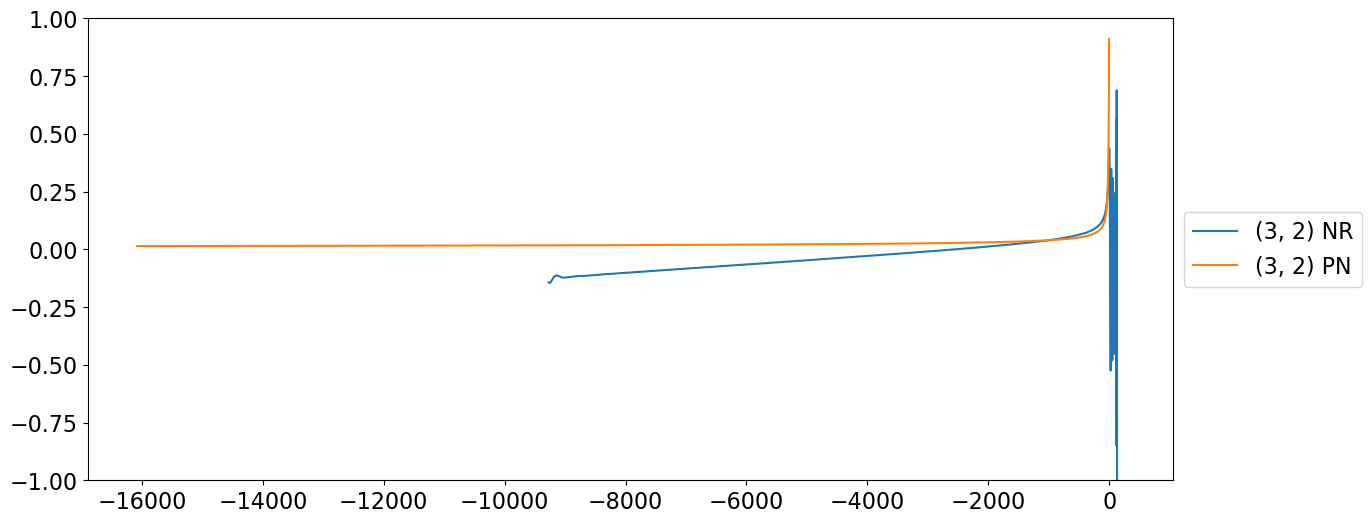

In [16]:
wf_nr = hybrid_utils.compute_phase(wf_nr)
plt.figure(figsize=(14, 6), dpi=100)
# for mode in wf_nr['hlm'].keys():
for mode in [(3,2)]:
    ell=mode[0]
    mm=mode[1]
    nr_ = wf_nr['phase'][mode] - (wf_nr['phase'][2,2]/2 * mm)
    pr_ = wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)
    
    # plt.plot(wf_nr['t'], nr_-nr_[0], label=f"{mode} NR")
    # plt.plot(wf_pn['t'], pr_-pr_[0], label=f"{mode} PN")
    plt.plot(wf_nr['t'], nr_, label=f"{mode} NR")
    plt.plot(wf_pn['t'], pr_, label=f"{mode} PN")
    # plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
# plt.ylim(-0.1, 0.1)
plt.ylim(-1,1)
# plt.ylim(-1.8, -1.5)
# plt.ylim(1,2)
# plt.xlim(-10000, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

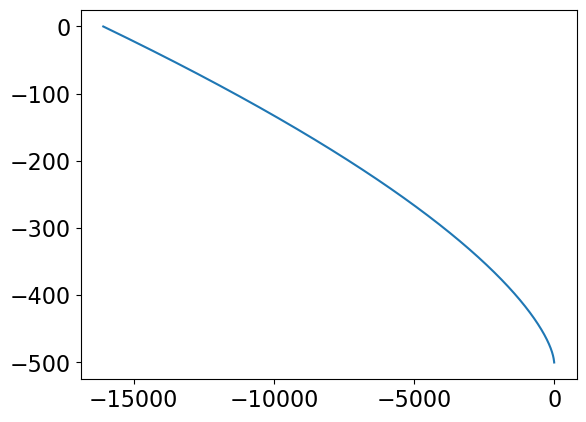

In [17]:
plt.plot(wf_pn['t'], wf_pn['phase'][2,2])

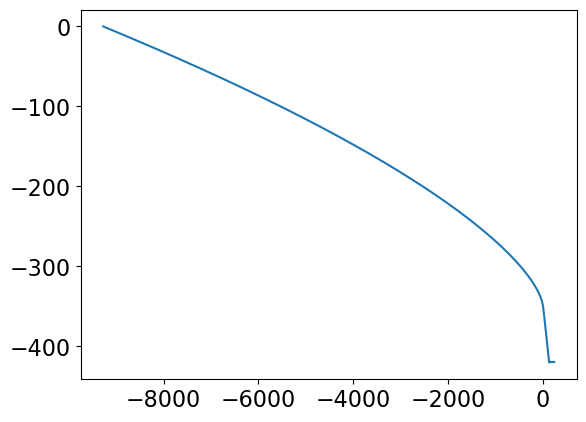

In [18]:
plt.plot(wf_nr['t'], wf_nr['phase'][2,2])

In [19]:
modes

[(2, 2), (3, 2), (4, 4)]

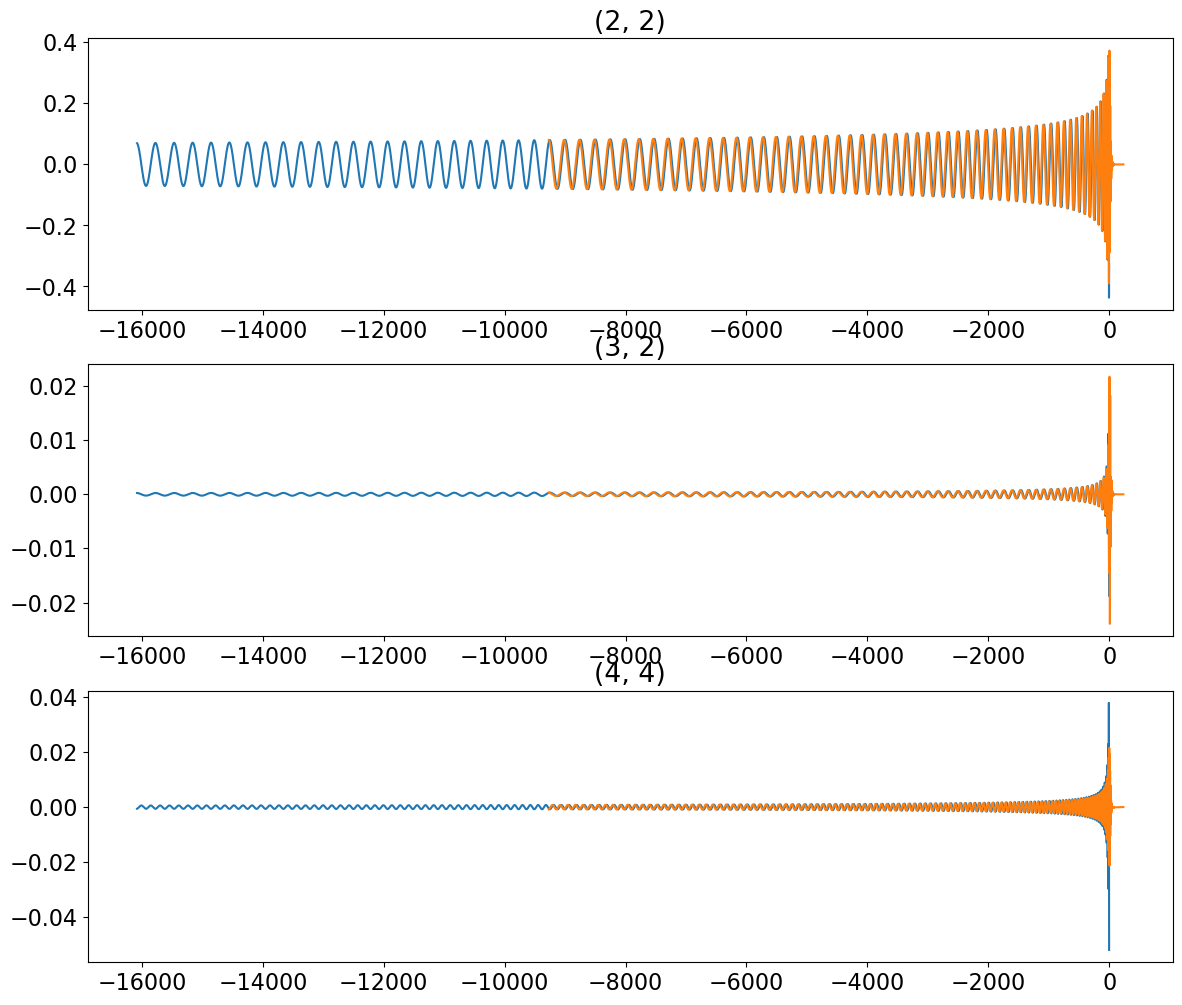

In [20]:

fig, axs = plt.subplots(len(modes), 1, figsize=(14, len(modes)*4))
for i, lm in enumerate(modes):
    axs[i].plot(wf_pn['t'], wf_pn['hlm'][lm].real)
    axs[i].plot(wf_nr['t'], wf_nr['hlm'][lm].real)
    axs[i].set_title(lm)
    #axs[i].plot(wf_pn['t'], np.abs(wf_pn['hlm'][lm]))
    #axs[i].plot(wf_nr['t'], np.abs(wf_nr['hlm'][lm]))
plt.show()

In [21]:
# t_start_pad = 0
# t_start_pad = 500
# t_start_pad = 400
# t_start_pad = 500
# t_start_pad = 4000
# wf_nr['mask'] = np.where( (wf_nr['t'] >= wf_nr['t'][0]+t_start_pad) & (wf_nr['t'] <= 0) )


# filter frequency to try and cure some non-monotonicity at the beginning
# window_length=int(3000*delta_t)
# polyorder=1
# filter_params=dict(window_length=window_length, polyorder=polyorder)
# filter_params=None



wf_nr = hybrid_utils.compute_frequency(wf_nr)
wf_pn = hybrid_utils.compute_frequency(wf_pn)

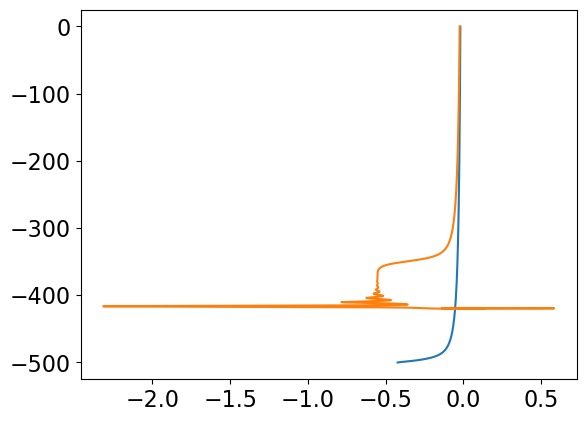

In [22]:
#####
plt.plot(wf_pn['freq'][2,2], wf_pn['phase'][2,2])
plt.plot(wf_nr['freq'][2,2], wf_nr['phase'][2,2])
#####

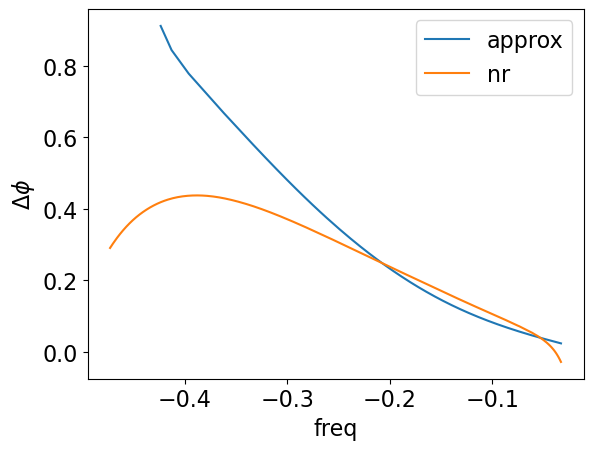

In [23]:
#####

mask = (wf_pn['t'] > -4000) & (wf_pn['t'] < 10)
plt.plot(wf_pn['freq'][2,2][mask], wf_pn['phase'][3,2][mask] - wf_pn['phase'][2,2][mask], label='approx')


mask = (wf_nr['t'] > -4000) & (wf_nr['t'] < 10)
plt.plot(wf_nr['freq'][2,2][mask], wf_nr['phase'][3,2][mask] - wf_nr['phase'][2,2][mask], label='nr')
plt.xlabel('freq')
plt.ylabel(r'$\Delta \phi$')
plt.legend()
#####

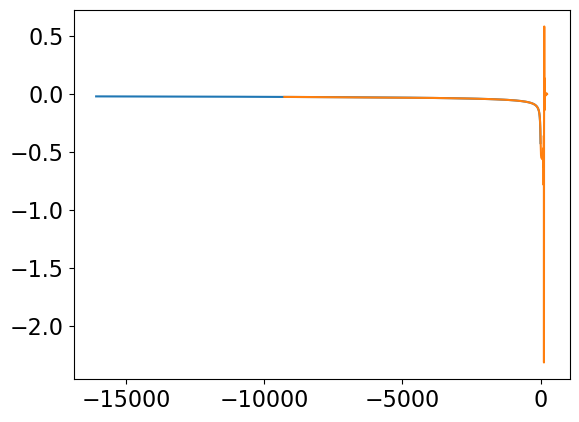

In [24]:
#####
plt.plot(wf_pn['t'], wf_pn['freq'][2,2])
plt.plot(wf_nr['t'], wf_nr['freq'][2,2])
#####

In [25]:
def estimate_t_of_f_with_poly_model(wf, mode=(2,2), polyorder=3):
    """
    polynomial fit (f,t) data using the first half of the data.
    returns
        poly1d function
        start time of fit domain
        end time of fit domain
    """
    t = wf['t']
    f = wf['freq'][mode]
    # model t(f) using the beginning of NR frequency with a cubic polynomial
    half_time = t[len(t)//2]
    mask = np.where( (t <= half_time) )
    z = np.polyfit(f[mask], t[mask], polyorder)
    p = np.poly1d(z)
    return p, t[mask][0], t[mask][-1]

In [26]:
p, t_fit_start, t_fit_end = estimate_t_of_f_with_poly_model(wf_nr, polyorder=3)

In [27]:
t_fit_start

-9270.545096147809

In [28]:
t_fit_end

-4517.045096130516

In [29]:
mask = np.where( (wf_nr['t'] >= t_fit_start) & (wf_nr['t'] <= t_fit_end ) )

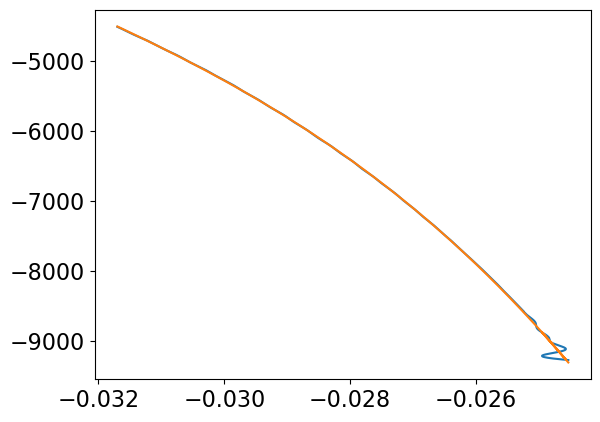

In [30]:
plt.plot(wf_nr['freq'][2,2][mask], wf_nr['t'][mask])
plt.plot(wf_nr['freq'][2,2][mask], p(wf_nr['freq'][2,2][mask]))

In [31]:
try:
    dt_, pn_time_of_nr = hybrid_utils.estimate_time_shift(wf_pn, wf_nr, mode=(2,2))
except:
    dt_=0
    pn_time_of_nr=wf_nr['t'][0]
# ff1, tt1 = hybrid_utils.estimate_time_shift(wf_pn, wf_nr, mode=(2,2))

In [32]:
#fit
# -7466.359232085662
# -4372.67474124732

In [33]:
dt_

3.8178697809744335

In [34]:
pn_time_of_nr

-9274.362965928784

In [35]:
wf_nr['hlm'].keys()

dict_keys([(2, 2), (3, 2), (4, 4)])

In [36]:
# wf_nr['mask'] = np.where( (wf_nr['t'] <= 0) )
wf_nr = hybrid_utils.compute_phase(wf_nr)
win1, win2 = hybrid_utils.estimate_window_from_phase(
    wf_nr,
    dt_=dt_,
    t0=pn_time_of_nr,
    n_cycles_before_window=2,
    n_cyles_in_window=6,
    # n_cyles_in_window=20,
)
win1, win2

(-8768.566319068794, -7310.088970571324)

In [37]:
pn_time_of_nr

-9274.362965928784

In [38]:
win1

-8768.566319068794

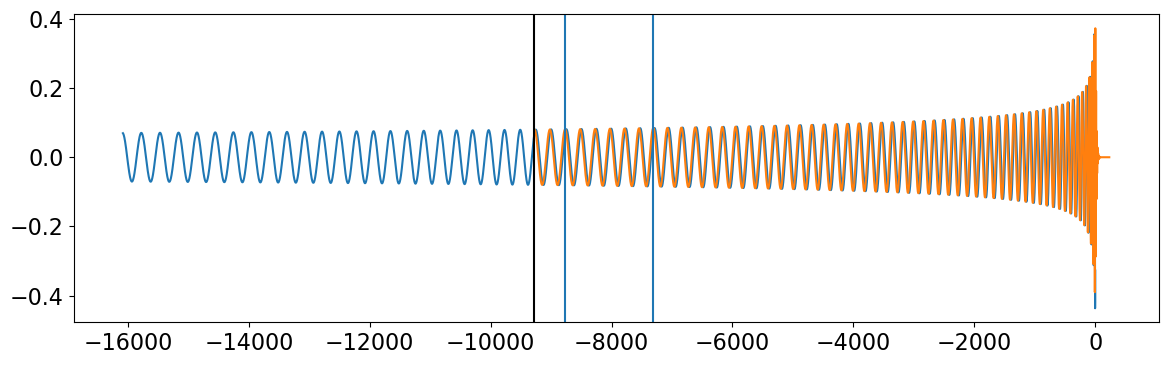

In [39]:
plt.figure(figsize=(14,4), dpi=100)
plt.plot(wf_pn['t'], wf_pn['hlm'][2,2].real)
plt.plot(wf_nr['t'] - dt_, wf_nr['hlm'][2,2].real)
plt.axvline(win1)
plt.axvline(win2)
plt.axvline(pn_time_of_nr, c='k')
# plt.xlim(win1-1000, win2+1000)

In [40]:
def fit_hybrid(wf_pn, wf_nr, win1, win2, modes, time_shift_guess, normalise_modes=True, n_tries=5, max_nfev=None):
    """
    wf_pn: waveform dict for pn waveform
    wf_nr: waveform dict for nr waveform
    win1: start time of hybrid window, in pn times
    win2: end time of hybrid window, in pn times
    modes: list of tuples of which modes to use to fit
    normalise_modes: bool default True. whether to fit to normalised modes or not.
    """
    wf_pn = wf_pn.copy()
    wf_nr = wf_nr.copy()

    # normalise each mode by max(abs(hlm))
    # this might make it easier to fit
    # and we are not fitting anything amplitude related
    # only time shift and rotations.
    # this will only make the amplitudes between NR and PN approximately the same

    ##############################
    # prepare nr data
    nr_x = wf_nr['t']
    if normalise_modes == True:
        wf_nr['hlm_norm']={}
        for k in modes:
            wf_nr['hlm_norm'][k] = wf_nr['hlm'][k] / np.max(np.abs(wf_nr['hlm'][k]))
    
        nr_y=wf_nr['hlm_norm']
    else:
        nr_y=wf_nr['hlm']
    #
    ##############################


    ##############################
    # prepare PN data
    mask = np.where( (wf_pn['t']>=win1) & (wf_pn['t']<=win2) )
    x_fit = wf_pn['t'][mask]
    
    # it seems like a good idea to normalise the modes when fitting
    # turn this into a function
    y_fits = []
    for k in modes:
        if normalise_modes == True:
            norm = np.max(np.abs(wf_pn['hlm'][k]))
        else:
            norm = 1
        y_fits.append(wf_pn['hlm'][k][mask] / norm)
    y_fit = np.concatenate(y_fits)
    #
    ##############################

    # need to fit each waveform multiple times
    # with either dpsi fixed to either 0 or pi/2
    # and then with random dphis to avoid local minima
    # pick the model with smallest redchis

    # it's 0 or pi/2 because we define it as exp(i*2*psi0)
    # sometimes people define it as exp(i*psi0) in which case it would be 0 or pi

    # psi=0
    results_psi_0 = []
    chisq_psi_0 = []

    # psi=pi/2
    results_psi_pi2 = []
    chisq_psi_pi2 = []

    model = lmfit.Model(hybrid_utils.MultimodeHybridModel, hlm_nr_x=nr_x, hlm_nr_y=nr_y)

    # parallelise this loop?
    for i in range(n_tries):
        # psi=0
        params = model.make_params(
                        dt=dict(value=time_shift_guess),
                        dphi=dict(value=np.random.uniform(0,2*np.pi), min=0, max=2*np.pi),
                        dpsi=dict(value=0, vary=False) # only allowed values 0, pi/2 (and pi, this is degenerate with 0)?
                )
        
        result = model.fit(y_fit, params, x=x_fit, max_nfev=max_nfev)
        results_psi_0.append(result)
        chisq_psi_0.append(result.redchi)

        # psi=pi/2
        params = model.make_params(
                        dt=dict(value=time_shift_guess),
                        dphi=dict(value=np.random.uniform(0,2*np.pi), min=0, max=2*np.pi),
                        dpsi=dict(value=np.pi/2, vary=False) # only allowed values 0, pi/2 (and pi, this is degenerate with 0)?
                )
        
        result = model.fit(y_fit, params, x=x_fit, max_nfev=max_nfev)
        results_psi_pi2.append(result)
        chisq_psi_pi2.append(result.redchi)


    psi_0_best_idx = np.argmin(chisq_psi_0)
    psi_0_best_value = chisq_psi_0[psi_0_best_idx]
    
    psi_pi2_best_idx = np.argmin(chisq_psi_pi2)
    psi_pi2_best_value = chisq_psi_pi2[psi_pi2_best_idx]

    # return model with smallest chisquare
    if psi_0_best_value <= psi_pi2_best_value:
        return results_psi_0[psi_0_best_idx]
    else:
        return results_psi_pi2[psi_pi2_best_idx]


In [41]:
import lmfit

In [42]:
%%time
# we use max_nfev especially when we have q=1 waveforms where there are no odd-m modes
# as I think otherwise the minimiser gets stuck
# result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2)], dt_, n_tries=3)
# result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2),(2,1),(3,2),(4,4)], dt_, n_tries=5, max_nfev=100)
# result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2),(2,1),(4,4)], dt_, n_tries=5, max_nfev=100)

# result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2),(2,1),(3,3),(4,4)], dt_, n_tries=10, max_nfev=100)
# result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2),(2,1),(3,3)], dt_, n_tries=10, max_nfev=100)

# result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2),(2,1),(3,3),(3,2),(4,4)], dt_, n_tries=10)
result = fit_hybrid(wf_pn, wf_nr, win1, win2, [(2,2),(3,2),(4,4)], dt_, n_tries=10)

CPU times: user 53 s, sys: 2.3 s, total: 55.3 s
Wall time: 55.9 s


In [43]:
result

In [44]:
def plot_hybrid(wf_pn, wf_nr, ell, mm, result, win1, win2, xlim=None):
    dt_ = result.params['dt']
    dphi_ = result.params['dphi']
    dpsi_ = result.params['dpsi']
    
    fig, axs = plt.subplots(2, 1, figsize=(14,8))
    axs[0].plot(wf_pn['t'], wf_pn['hlm'][ell,mm].real, label='pn')
    axs[0].plot(wf_nr['t']-dt_, (wf_nr['hlm'][ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).real, label='aligned nr', ls='--')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].axvspan(win1, win2, color='g', alpha=0.2)

    axs[1].plot(wf_pn['t'], wf_pn['hlm'][ell,mm].imag, label='pn')
    axs[1].plot(wf_nr['t']-dt_, (wf_nr['hlm'][ell,mm]*np.exp(1.j*mm*dphi_)*np.exp(1.j*2*dpsi_)).imag, label='aligned nr', ls='--')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].axvspan(win1, win2, color='g', alpha=0.2)

    fig.suptitle(f"l = {ell}, m = {mm}")

    if xlim != None:
        axs[0].set_xlim(xlim[0], xlim[1])
        axs[1].set_xlim(xlim[0], xlim[1])
    plt.show()
    plt.close()

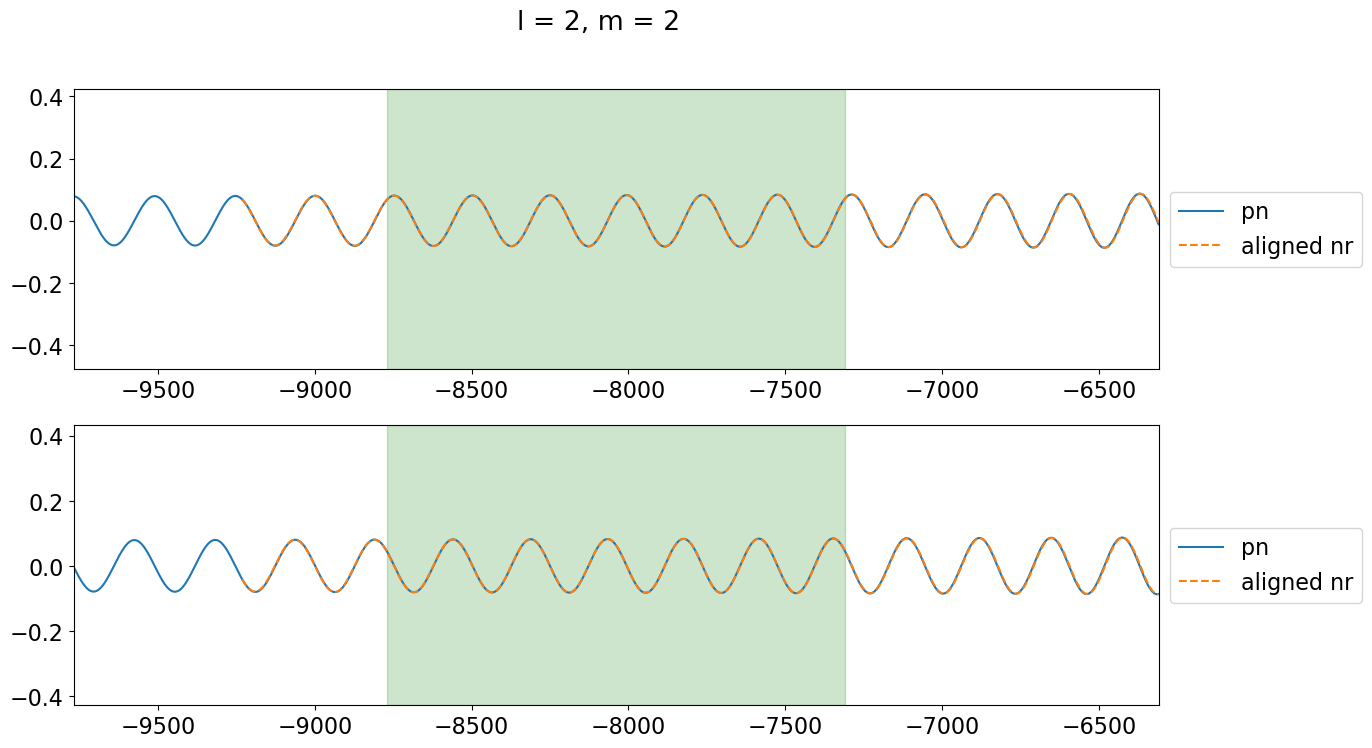

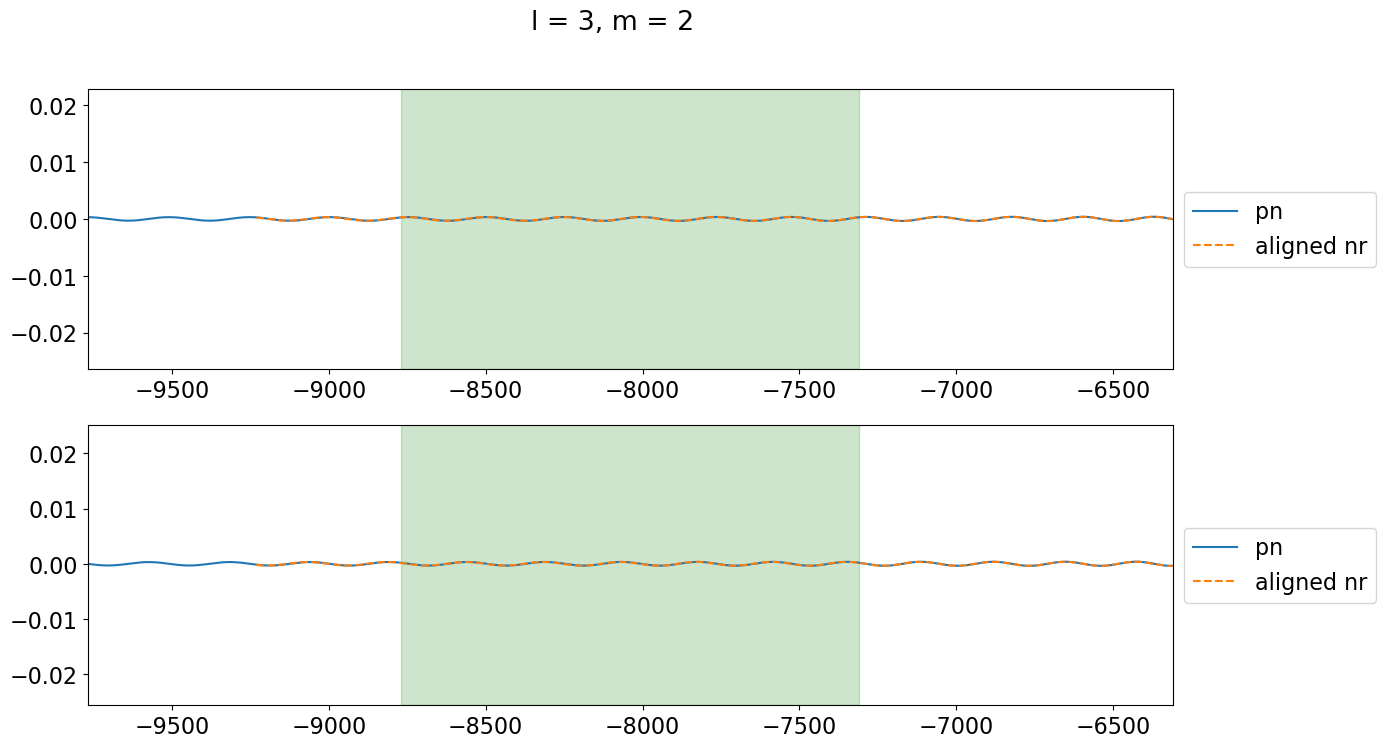

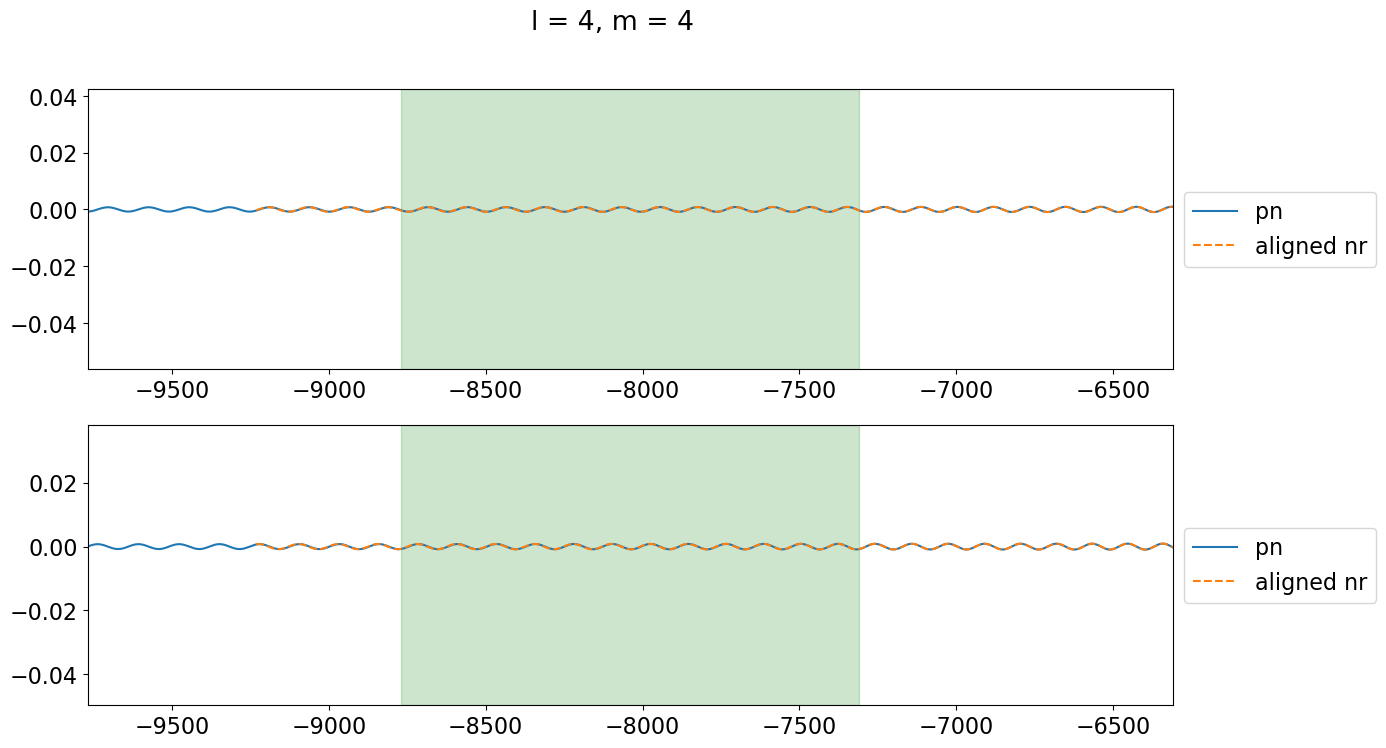

In [45]:
for lm in wf_nr['hlm'].keys():
    xlim=(win1-1000, win2+1000)
    # xlim=None
    # xlim=(-100, 100)
    plot_hybrid(wf_pn, wf_nr, lm[0], lm[1], result, win1, win2, xlim)

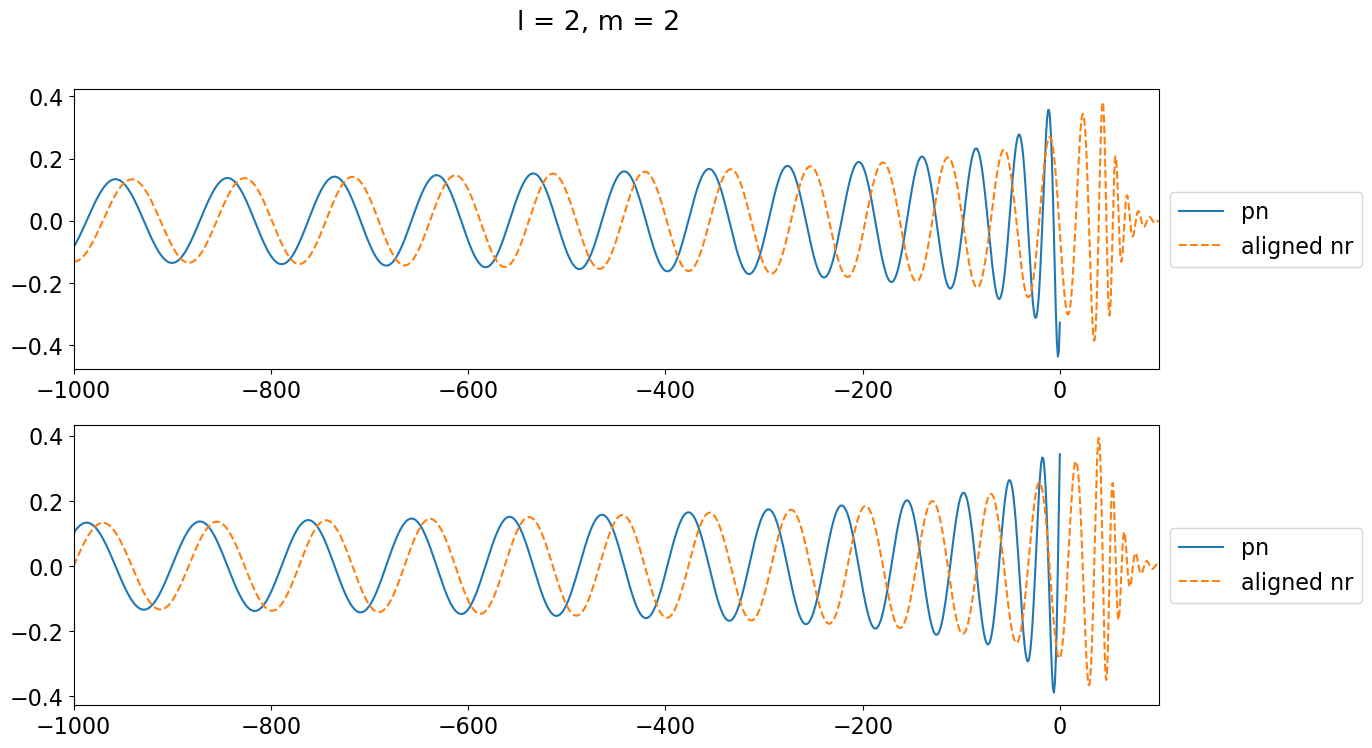

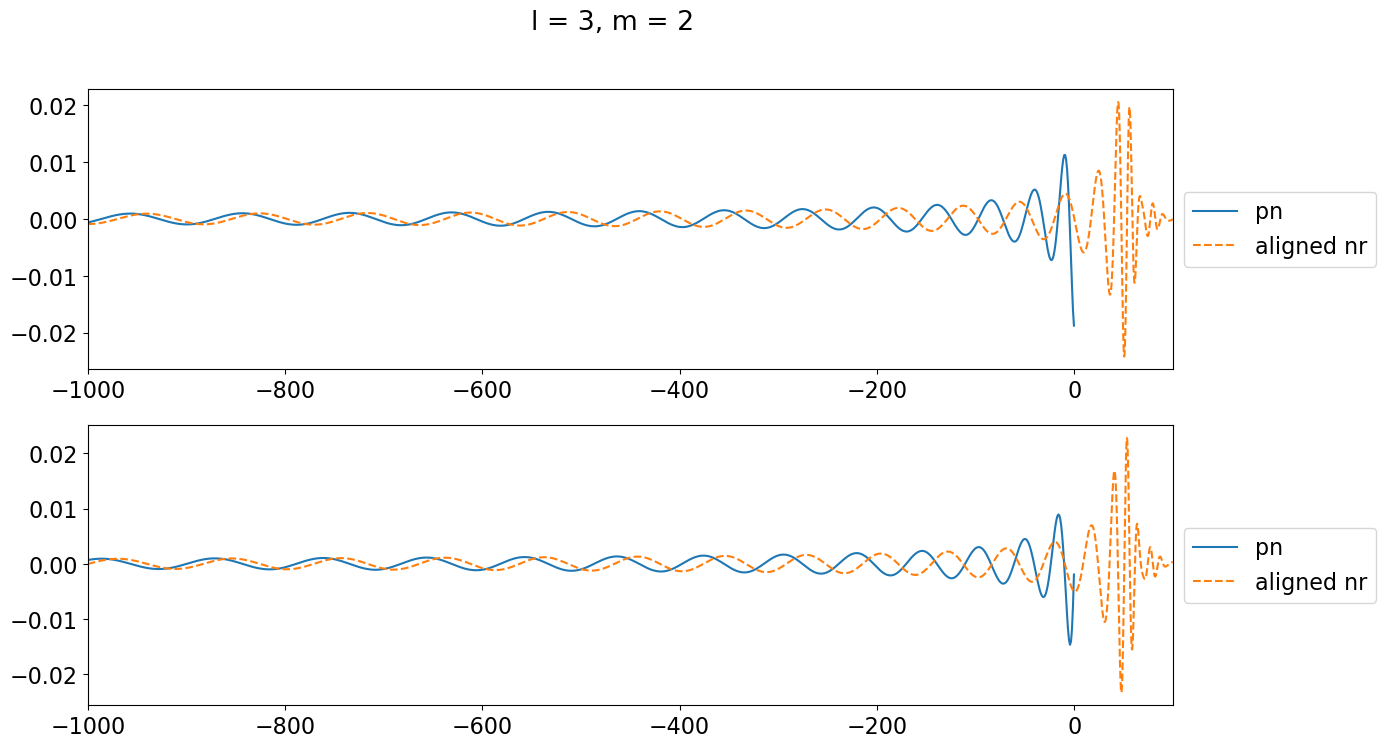

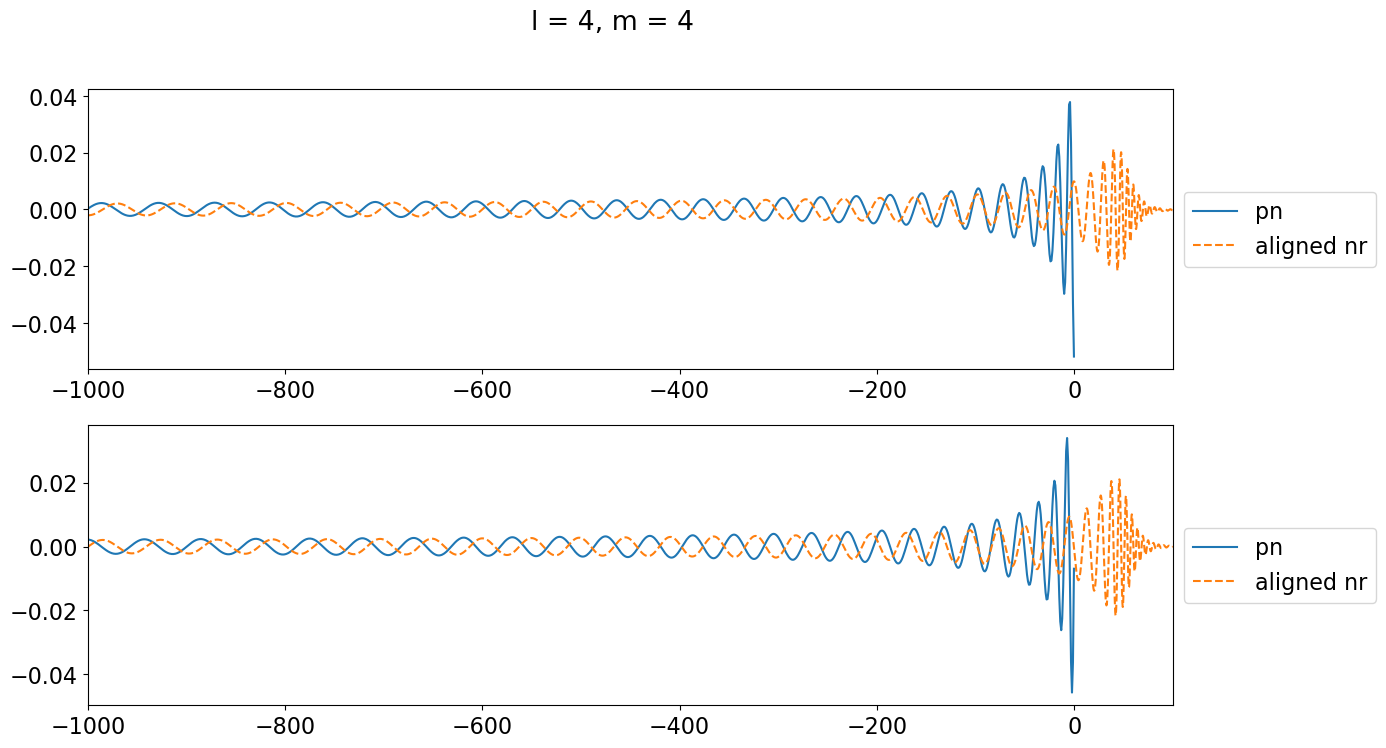

In [46]:
for lm in wf_nr['hlm'].keys():
    # xlim=(win1-1000, win2+1000)
    # xlim=None
    xlim=(-1000, 100)
    plot_hybrid(wf_pn, wf_nr, lm[0], lm[1], result, win1, win2, xlim)

In [47]:
# then blend
# time align
# phase shift

In [48]:
def blending_function(t, win1, win2):
    """
    https://arxiv.org/abs/1812.07865
    """
    tau = np.zeros(len(t))
    mask = np.where( (t>=win1) & (t<=win2) )

    frac=(t[mask]-win1)/(win2-win1)
    
    tau[mask] = np.sin(0.5*np.pi*frac)**2
    mask = np.where(t>win2)
    tau[mask] = 1
    return tau

In [49]:
def build_hybrid(wf_pn, wf_nr, dt, dphi, dpsi, win1, win2, delta_t=None):
    """
    delta_t: output delta_t for hybrid, default None. If None then will use PN delta_t/4
    """

    # loop over all modes in waveform dict
    # apply hybridisation to each mode
    # todo: apply global time and phase shift
    
    modes = list(wf_nr['hlm'].keys())

    # use 2,2 mode to get common time array
    wf_pn_x = wf_pn['t']
    wf_nr_x_shifted = wf_nr['t']-dt
    
    t_start = np.min([wf_pn_x[0], wf_nr_x_shifted[0]])
    t_end = np.max([wf_pn_x[-1], wf_nr_x_shifted[-1]])
    if delta_t == None:
        delta_t = (wf_pn_x[1] - wf_pn_x[0])/4
    times = np.arange(t_start, t_end, delta_t)    

    # window/blending function
    tau = blending_function(times, win1, win2)
    
    wf_hybrid = {}
    wf_hybrid['hlm'] = {}
    
    for i, mode in enumerate(modes):
        ell = mode[0]
        mm = mode[1]

        # get PN waveform
        wf_pn_x = wf_pn['t']
        wf_pn_y = wf_pn['hlm'][ell, mm]

        # get NR waveform and apply time, phase and polarisation shifts
        wf_nr_x_shifted = wf_nr['t']-dt
        wf_nr_y_shifted = wf_nr['hlm'][ell, mm]*np.exp(1.j*mm*dphi)*np.exp(1.j*2*dpsi)
        
        # plt.plot(wf_pn_x, wf_pn_y.real)
        # plt.plot(wf_nr_x_shifted, wf_nr_y_shifted.real)

        # interpolate real and imag PN and NR waveforms
        # by setting the extrapolation behaviour like this
        # we can easily zero pad the left and right to the same time array
        # and then easily multiply the window function
        
        hybrid_pn_real = IUS(wf_pn_x, wf_pn_y.real, ext=1)(times) * (1-tau)
        hybrid_nr_real = IUS(wf_nr_x_shifted, wf_nr_y_shifted.real, ext=1)(times) * tau
        hybrid_real = hybrid_pn_real + hybrid_nr_real
    
        hybrid_pn_imag = IUS(wf_pn_x, wf_pn_y.imag, ext=1)(times) * (1-tau)
        hybrid_nr_imag = IUS(wf_nr_x_shifted, wf_nr_y_shifted.imag, ext=1)(times) * tau
        hybrid_imag = hybrid_pn_imag + hybrid_nr_imag

        wf_hybrid['hlm'][mode] = hybrid_real + 1.j*hybrid_imag


    # time shift peak sum
    amps = []
    for mode in modes:
        amps.append(np.abs(wf_hybrid['hlm'][mode]))
    amps = np.array(amps)
    t_peak = times[np.argmax(amps.sum(0))]

    wf_hybrid['t'] = times - t_peak
    

    return wf_hybrid, t_peak


        

    # hybrid_amp = np.abs(hybrid_real+1.j*hybrid_imag)

    # t_peak_22 = times[np.argmax(hybrid_amp)]
    
    # plt.figure(figsize=(14, 6))
    # plt.plot(times-t_peak_22, hybrid_pn_real, label='PN')
    # plt.plot(times-t_peak_22, hybrid_nr_real, label='NR')
    # plt.plot(times-t_peak_22, hybrid_real, ls='--', label='Hybrid')
    # plt.plot(times-t_peak_22, hybrid_amp, ls='--', label='Hybrid amplitude')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # # plt.xlim(win1-6000, win2+3000)
    # plt.axvline(win1)
    # plt.axvline(win2)

    # plt.xlim(-500, 100)
    # # plt.ylim(-0.01/3,0.01/3)

In [50]:
wf_hybrid, t_peak = build_hybrid(wf_pn, wf_nr, result.params['dt'], result.params['dphi'], result.params['dpsi'], win1, win2)

In [51]:
t_peak

40.25451739935306

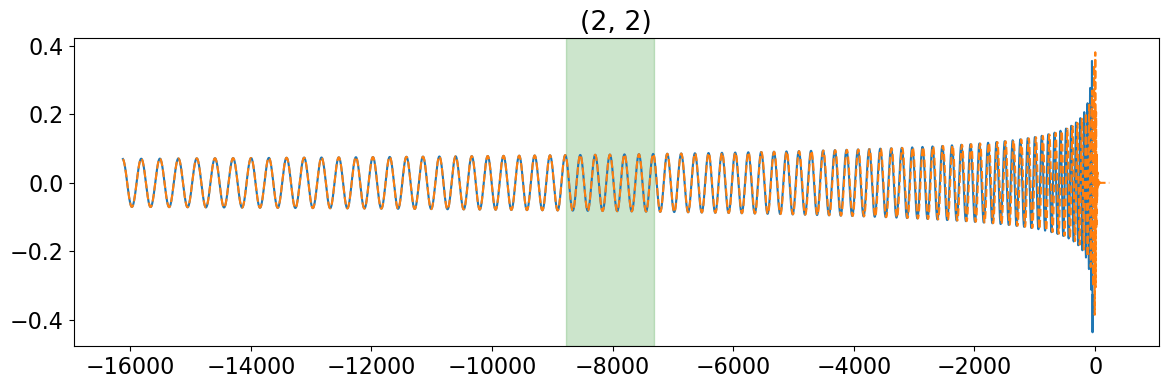

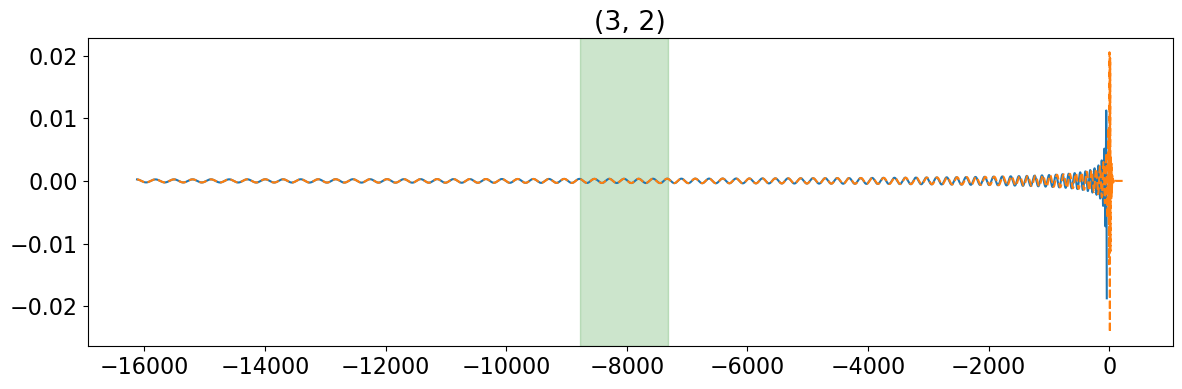

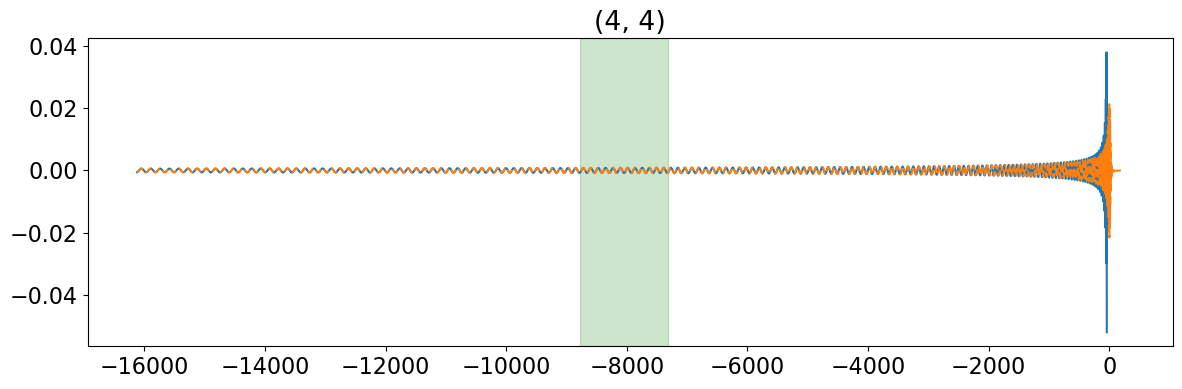

In [52]:
for mode in wf_hybrid['hlm'].keys():
    plt.figure(figsize=(14, 4))
        
    plt.plot(wf_pn['t'] - t_peak, wf_pn['hlm'][mode].real)
    plt.plot(wf_hybrid['t'], wf_hybrid['hlm'][mode].real, ls='--')
    plt.title(mode)
    # plt.xlim(-4000, 100)
    plt.axvspan(win1, win2, color='g', alpha=0.2)
    plt.show()
    plt.close()

In [53]:
wf_hybrid = hybrid_utils.compute_phase(wf_hybrid)

In [54]:
wf_hybrid['hlm'].keys()

dict_keys([(2, 2), (3, 2), (4, 4)])

In [55]:
# my procedure produces phases
# that have phi_lm = m*phi_22/2 to be exact during the inspiral
# which doesn't seem to agree with the surrogate

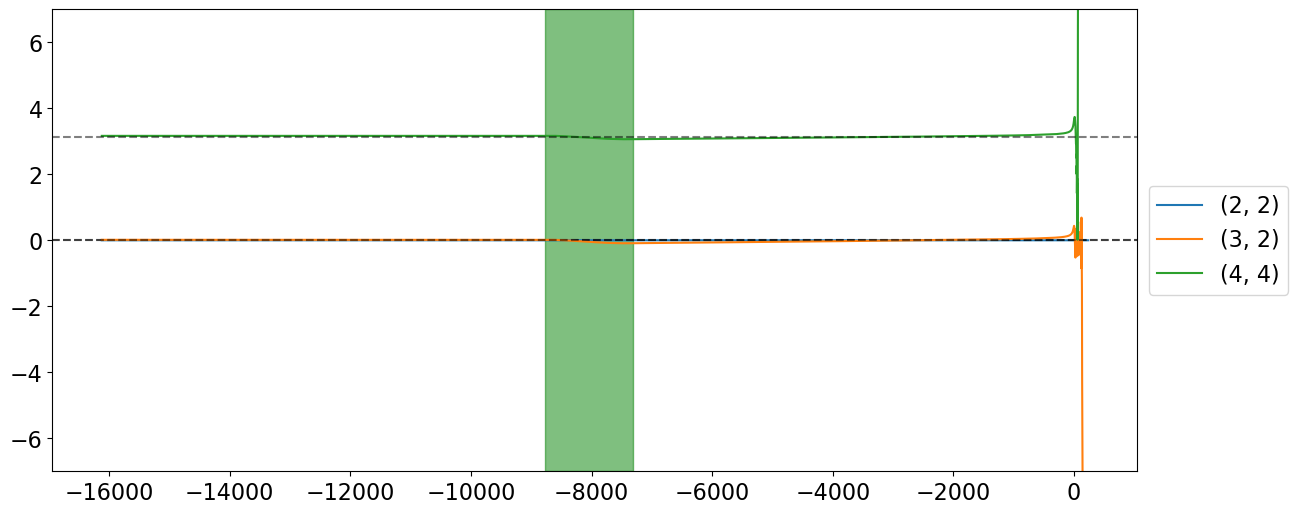

In [56]:
plt.figure(figsize=(14, 6), dpi=100)
for mode in wf_hybrid['hlm'].keys():
    ell=mode[0]
    mm=mode[1]
    # plt.plot(wf_hybrid['t'], wf_hybrid['phase'][mode] - (wf_hybrid['phase'][2,2]/2 * mm), label=mode)
    plt.plot(wf_hybrid['t'], np.unwrap(wf_hybrid['phase'][mode] - (wf_hybrid['phase'][2,2]/2 * mm)), label=mode)
    plt.axhline(delta_phi_fn(mm), c='k', ls='--', alpha=0.5)
plt.ylim(-7, 7)
# plt.xlim(-1000, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axvspan(win1, win2, color='g', alpha=0.5)

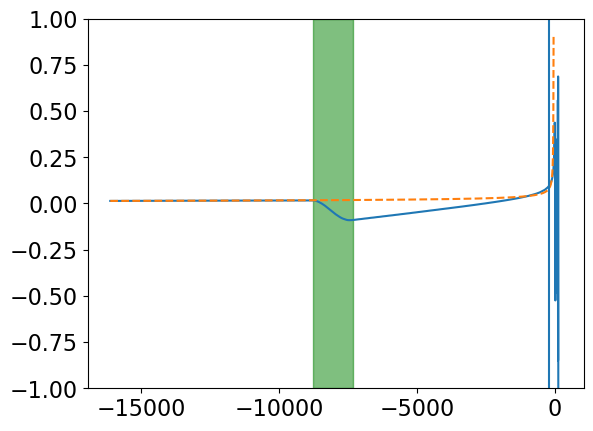

In [57]:
plt.plot(wf_hybrid['t'], wf_hybrid['phase'][(3,2)] - 2*wf_hybrid['phase'][2,2]/2)
plt.plot(wf_pn['t']-t_peak, wf_pn['phase'][(3,2)] - 2*wf_pn['phase'][2,2]/2, ls='--')
plt.ylim(-1, +1)

plt.axvspan(win1, win2, color='g', alpha=0.5)

plt.axvline(-200)
# plt.xlim(-500, 100)

(-500.0, 100.0)

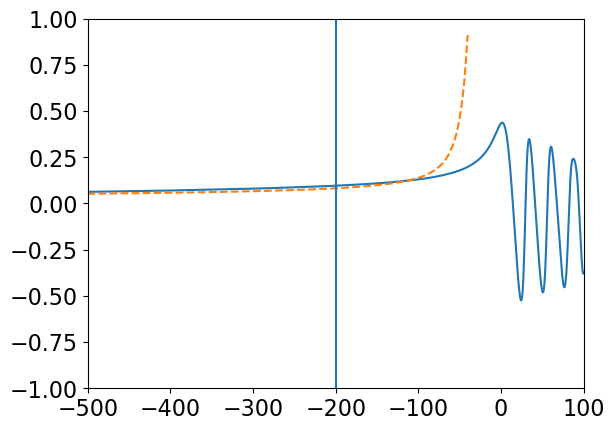

In [58]:
plt.plot(wf_hybrid['t'], wf_hybrid['phase'][(3,2)] - 2*wf_hybrid['phase'][2,2]/2)
plt.plot(wf_pn['t']-t_peak, wf_pn['phase'][(3,2)] - 2*wf_pn['phase'][2,2]/2, ls='--')
plt.ylim(-1, +1)

plt.axvspan(win1, win2, color='g', alpha=0.5)

plt.axvline(-200)
plt.xlim(-500, 100)

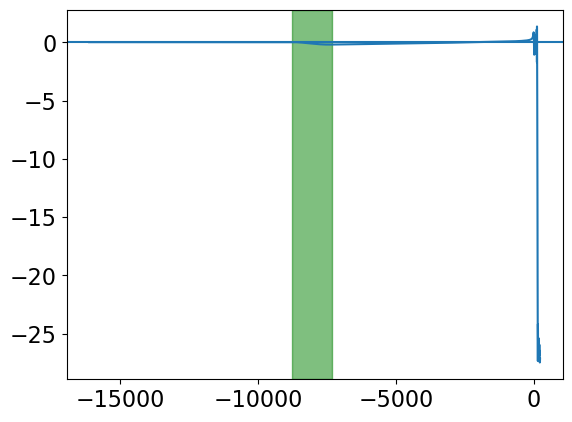

In [59]:
plt.plot(wf_hybrid['t'], np.unwrap(np.mod(2*wf_hybrid['phase'][(3,2)] - 2*wf_hybrid['phase'][2,2], 2*np.pi)))
plt.axhline(0)
# plt.ylim(-1, +1)

plt.axvspan(win1, win2, color='g', alpha=0.5)

In [60]:
# plt.plot(wf_hybrid['t'], np.unwrap(np.mod(2*wf_hybrid['phase'][(3,3)] - 3*wf_hybrid['phase'][2,2], 2*np.pi)))
# # plt.ylim(3,3.2)

# plt.axvspan(win1, win2, color='g', alpha=0.5)

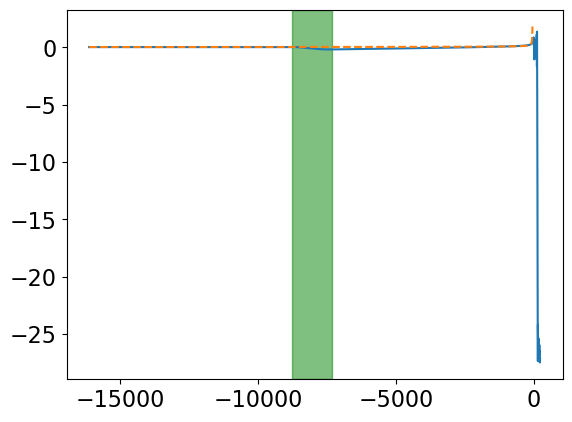

In [61]:
plt.plot(wf_hybrid['t'], np.unwrap(np.mod(2*wf_hybrid['phase'][(3,2)] - 2*wf_hybrid['phase'][2,2], 2*np.pi)))
plt.plot(wf_pn['t']-t_peak, np.unwrap(np.mod(2*wf_pn['phase'][(3,2)] - 2*wf_pn['phase'][2,2], 2*np.pi)), ls='--')
# plt.ylim(5,7)
# plt.ylim(-7,7)
# plt.ylim(6.25,6.5)

plt.axvspan(win1, win2, color='g', alpha=0.5)

In [62]:
# plt.plot(wf_hybrid['t'], np.unwrap(np.mod(2*wf_hybrid['phase'][(3,3)] - 3*wf_hybrid['phase'][2,2], 2*np.pi)))
# plt.plot(wf_pn['t']-t_peak, np.unwrap(np.mod(2*wf_pn['phase'][(3,3)] - 3*wf_pn['phase'][2,2], 2*np.pi)))
# plt.ylim(2,3.2)

# plt.axvspan(win1, win2, color='g', alpha=0.5)

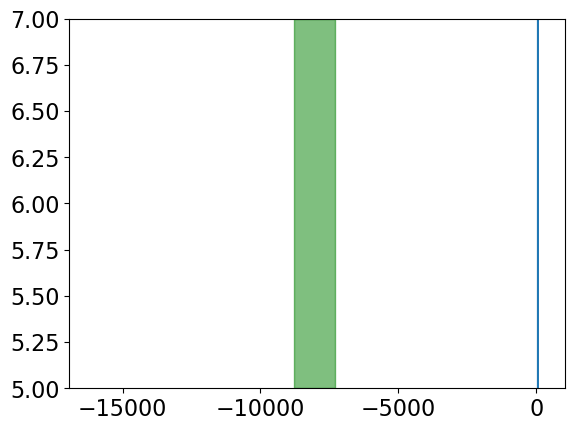

In [63]:
plt.plot(wf_hybrid['t'], np.unwrap(np.mod(2*wf_hybrid['phase'][(4,4)] - 4*wf_hybrid['phase'][2,2], 2*np.pi)))
plt.ylim(5,7.)
plt.axvspan(win1, win2, color='g', alpha=0.5)

In [64]:
wf_pn = hybrid_utils.compute_phase(wf_pn)

In [65]:
wf_hybrid = hybrid_utils.compute_phase(wf_hybrid)
wf_hybrid = hybrid_utils.compute_frequency(wf_hybrid)

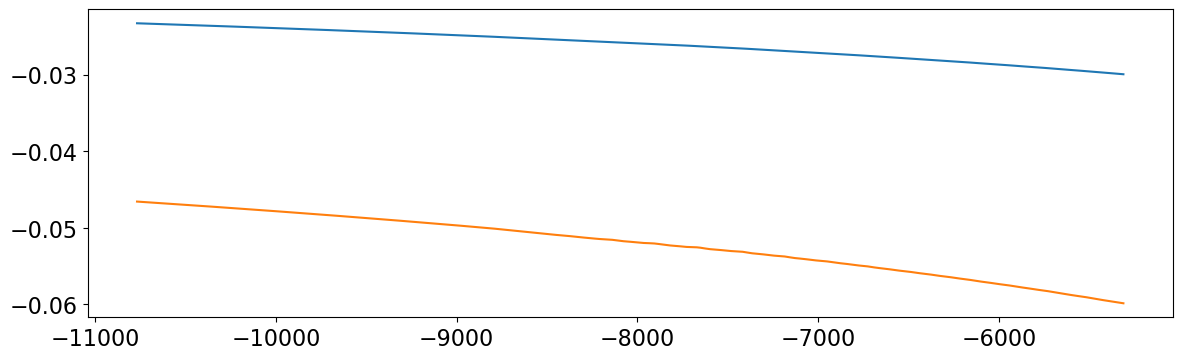

In [66]:
mask = np.where( (wf_hybrid['t'] >= win1-2000) & (wf_hybrid['t'] <= win2+2000) )

plt.figure(figsize=(14, 4))
plt.plot(wf_hybrid['t'][mask], wf_hybrid['freq'][2,2][mask])
# plt.plot(wf_hybrid['t'][mask], wf_hybrid['freq'][3,2][mask])
plt.plot(wf_hybrid['t'][mask], wf_hybrid['freq'][4,4][mask])
# plt.axvspan(win1, win2, color='g', alpha=0.5)

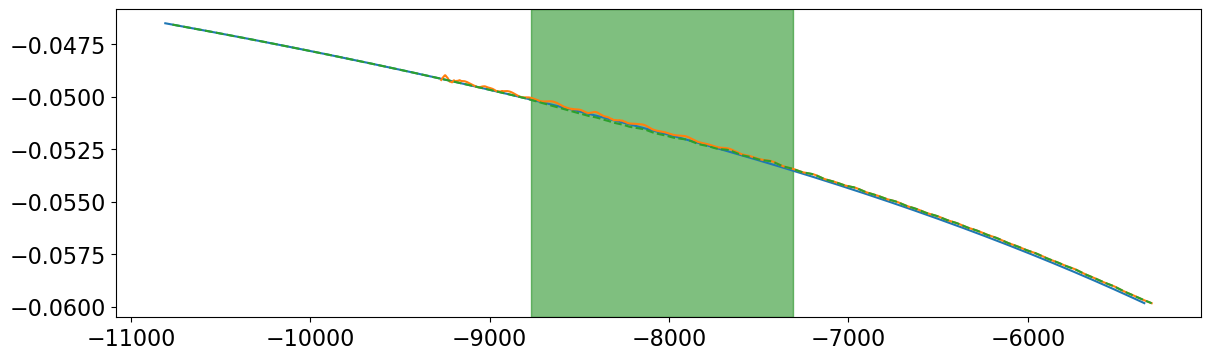

In [67]:
mask_pn = np.where( (wf_pn['t'] >= win1-2000) & (wf_pn['t'] <= win2+2000) )
mask_nr = np.where( (wf_nr['t'] >= win1-2000) & (wf_nr['t'] <= win2+2000) )

plt.figure(figsize=(14, 4))
# plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['freq'][2,2][mask_pn])
plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['freq'][4,4][mask_pn])
plt.plot(wf_nr['t'][mask_nr], wf_nr['freq'][4,4][mask_nr])
plt.plot(wf_hybrid['t'][mask], wf_hybrid['freq'][4,4][mask], ls='--')
plt.axvspan(win1, win2, color='g', alpha=0.5)

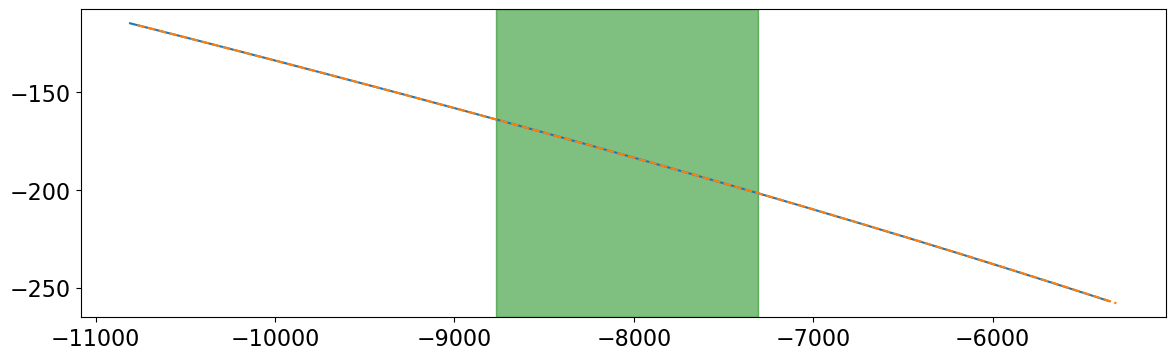

In [68]:
plt.figure(figsize=(14, 4))
# plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['freq'][2,2][mask_pn])
plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['phase'][2,2][mask_pn])
plt.plot(wf_hybrid['t'][mask], wf_hybrid['phase'][2,2][mask], ls='--')
plt.axvspan(win1, win2, color='g', alpha=0.5)

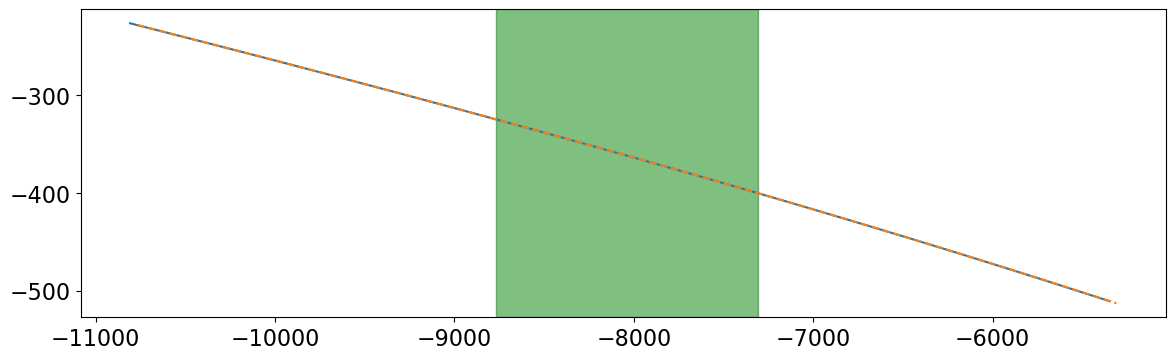

In [69]:
plt.figure(figsize=(14, 4))
# plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['freq'][2,2][mask_pn])
plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['phase'][4,4][mask_pn])
plt.plot(wf_hybrid['t'][mask], wf_hybrid['phase'][4,4][mask], ls='--')
plt.axvspan(win1, win2, color='g', alpha=0.5)

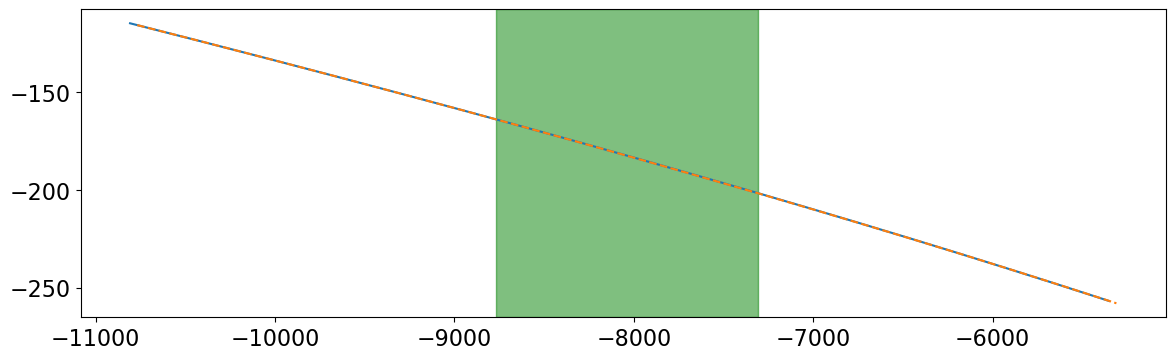

In [70]:
plt.figure(figsize=(14, 4))
# plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['freq'][2,2][mask_pn])
plt.plot(wf_pn['t'][mask_pn]-t_peak, wf_pn['phase'][3,2][mask_pn])
plt.plot(wf_hybrid['t'][mask], wf_hybrid['phase'][3,2][mask], ls='--')
plt.axvspan(win1, win2, color='g', alpha=0.5)

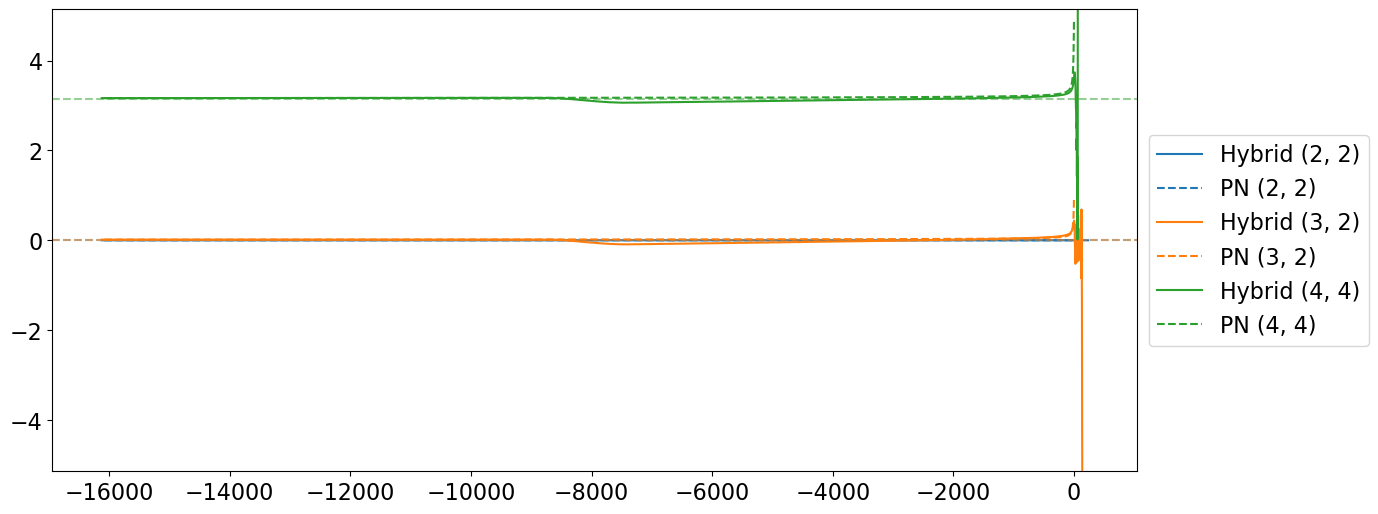

In [71]:
wf_nr = hybrid_utils.compute_phase(wf_nr)
plt.figure(figsize=(14, 6), dpi=100)
for i, mode in enumerate(wf_pn['hlm'].keys()):
    ell=mode[0]
    mm=mode[1]
    plt.plot(wf_hybrid['t'], np.unwrap(wf_hybrid['phase'][mode] - (wf_hybrid['phase'][2,2]/2 * mm)), label=f"Hybrid {mode}", c=f'C{i}')
    plt.plot(wf_pn['t'], np.unwrap(wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)), label=f"PN {mode}", ls='--', c=f'C{i}')
    plt.axhline(delta_phi_fn(mm), c=f'C{i}', ls='--', alpha=0.5)
plt.ylim(-np.pi-2, np.pi+2)
# plt.xlim(-4000, -10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

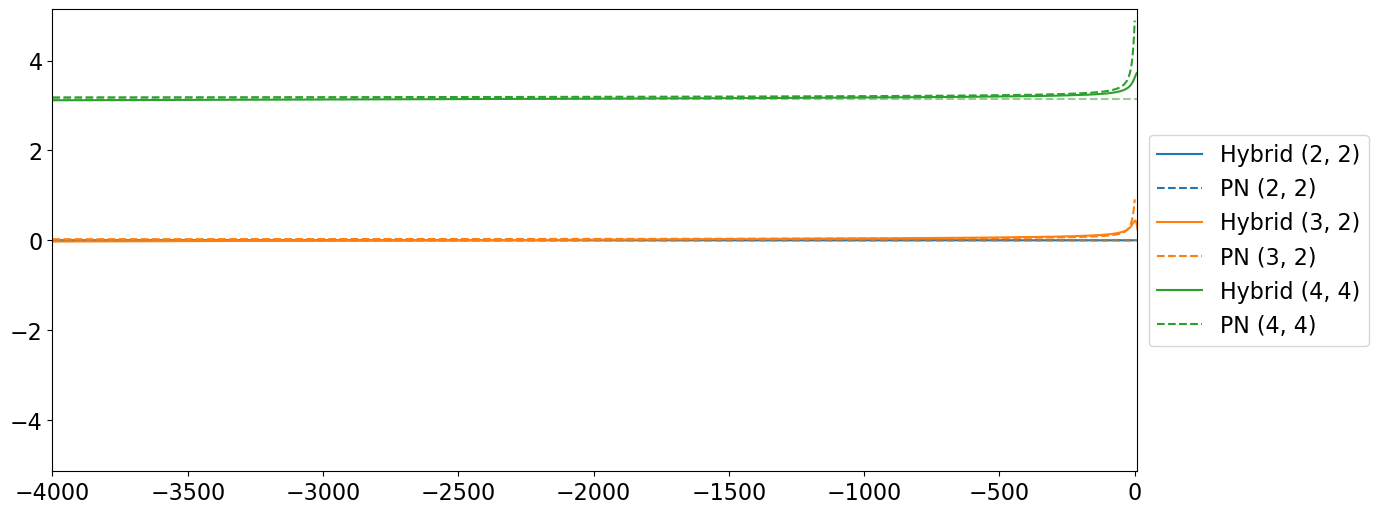

In [72]:
wf_nr = hybrid_utils.compute_phase(wf_nr)
plt.figure(figsize=(14, 6), dpi=100)
for i, mode in enumerate(wf_pn['hlm'].keys()):
    ell=mode[0]
    mm=mode[1]
    plt.plot(wf_hybrid['t'], np.unwrap(wf_hybrid['phase'][mode] - (wf_hybrid['phase'][2,2]/2 * mm)), label=f"Hybrid {mode}", c=f'C{i}')
    plt.plot(wf_pn['t'], np.unwrap(wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)), label=f"PN {mode}", ls='--', c=f'C{i}')
    plt.axhline(delta_phi_fn(mm), c=f'C{i}', ls='--', alpha=0.5)
plt.ylim(-np.pi-2, np.pi+2)
plt.xlim(-4000, 10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

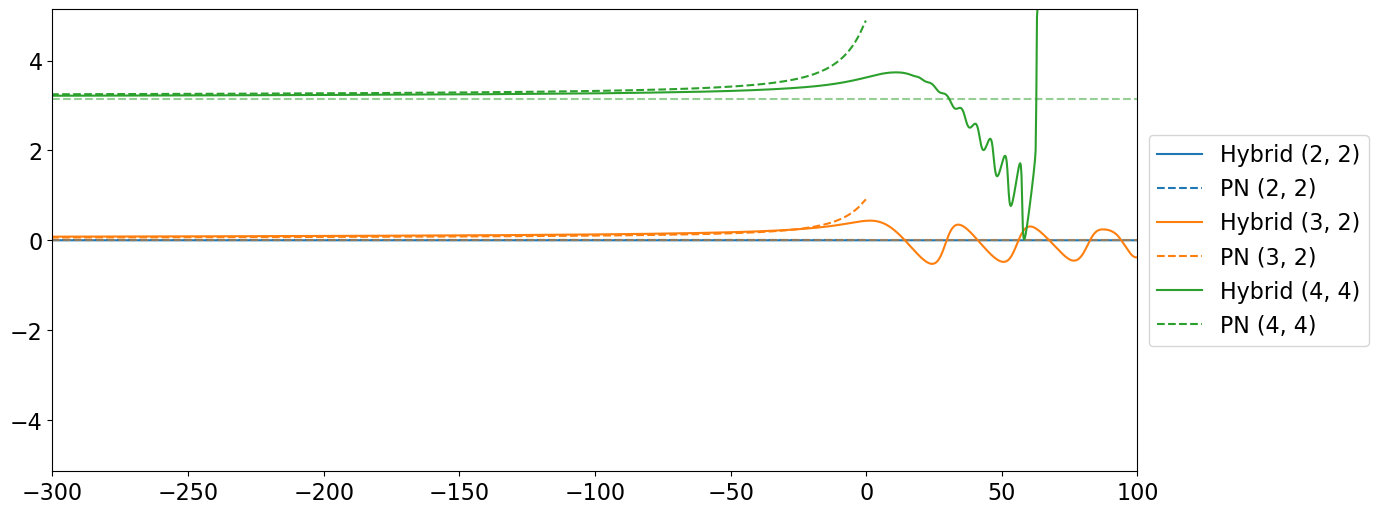

In [73]:
wf_nr = hybrid_utils.compute_phase(wf_nr)
plt.figure(figsize=(14, 6), dpi=100)
for i, mode in enumerate(wf_pn['hlm'].keys()):
    ell=mode[0]
    mm=mode[1]
    plt.plot(wf_hybrid['t'], np.unwrap(wf_hybrid['phase'][mode] - (wf_hybrid['phase'][2,2]/2 * mm)), label=f"Hybrid {mode}", c=f'C{i}')
    plt.plot(wf_pn['t'], np.unwrap(wf_pn['phase'][mode] - (wf_pn['phase'][2,2]/2 * mm)), label=f"PN {mode}", ls='--', c=f'C{i}')
    plt.axhline(delta_phi_fn(mm), c=f'C{i}', ls='--', alpha=0.5)
plt.ylim(-np.pi-2, np.pi+2)
plt.xlim(-300, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

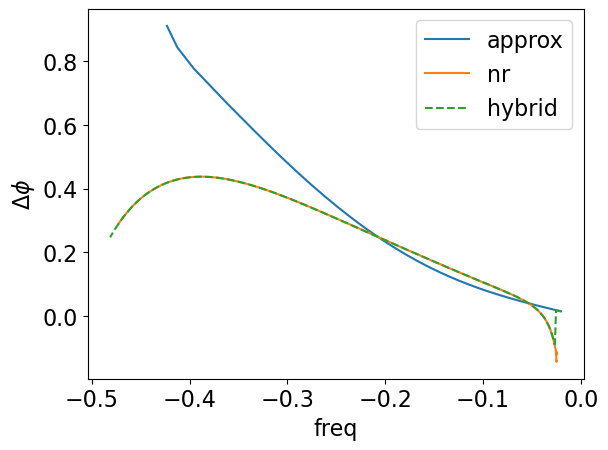

In [74]:
#####

mask = (wf_pn['t'] > -40000) & (wf_pn['t'] < 10)
plt.plot(wf_pn['freq'][2,2][mask], wf_pn['phase'][3,2][mask] - wf_pn['phase'][2,2][mask], label='approx')


mask = (wf_nr['t'] > -40000) & (wf_nr['t'] < 10)
plt.plot(wf_nr['freq'][2,2][mask], wf_nr['phase'][3,2][mask] - wf_nr['phase'][2,2][mask], label='nr')


mask = (wf_hybrid['t'] > -40000) & (wf_hybrid['t'] < 10)
plt.plot(wf_hybrid['freq'][2,2][mask], wf_hybrid['phase'][3,2][mask] - wf_hybrid['phase'][2,2][mask], label='hybrid', ls='--')

plt.xlabel('freq')
plt.ylabel(r'$\Delta \phi$')
plt.legend()
#####